# [Quick practice] Predicting Customer Churn

- No checks for potential bias
- Assumes all assumptions are met
- Try out lifelines package


Quick review of Survival Analysis concepts: [YouTube Series](https://www.youtube.com/watch?v=vX3l36ptrTU&list=PLqzoL9-eJTNDdnKvep_YHIwk2AMqHhuJ0
)

Lifelines code and survival analysis tutorial: [Documentation](https://lifelines.readthedocs.io/en/latest/index.html)


In [1]:
import os
import sys
sys.path.append('../../datasets/')

import numpy as np
import pandas as pd
import lifelines as sv
import seaborn as sns
import matplotlib.pyplot as plt
import download

data_path = os.path.expanduser('~')+'/data_science/datasets/data/'

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
# !pip intall lifelines 

# Load data

- Read about the data [here](https://www.kaggle.com/blastchar/telco-customer-churn).


In [3]:
#Download via Kaggle API
dataset  = 'blastchar/telco-customer-churn'
filename = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
download.dnld_kaggle_data(dataset, filename)

Data already exist!


In [4]:
telco_df = pd.read_csv(data_path+filename)
print(telco_df.shape)
print(telco_df.columns)
display(telco_df.info())
display(telco_df.head(2))

(7043, 21)
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport

None

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


# Explore data


In [5]:
for c in telco_df.columns:
    print(f'{c}: {telco_df[c].unique()}')

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

In [6]:
#Sanity checks
print(telco_df.customerID.duplicated().any())
print(telco_df.query("InternetService=='No'").TechSupport.unique())
print(telco_df.query("InternetService=='No'").PhoneService.unique())

False
['No internet service']
['Yes']


*So those with no internet have Phone Service. No tech support for phone service only? 
Look into those with internet service only to simplify this quick analysis.*

In [7]:
telco_df.query("Partner=='No'").Dependents.value_counts()

No     3280
Yes     361
Name: Dependents, dtype: int64

In [8]:
telco_df.query("Partner=='Yes'").Dependents.value_counts()

Yes    1749
No     1653
Name: Dependents, dtype: int64

In [9]:
#Use some categorical features only
cols = [
 'tenure',
 'Churn',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'Contract',
 'PaperlessBilling',
 'TechSupport']

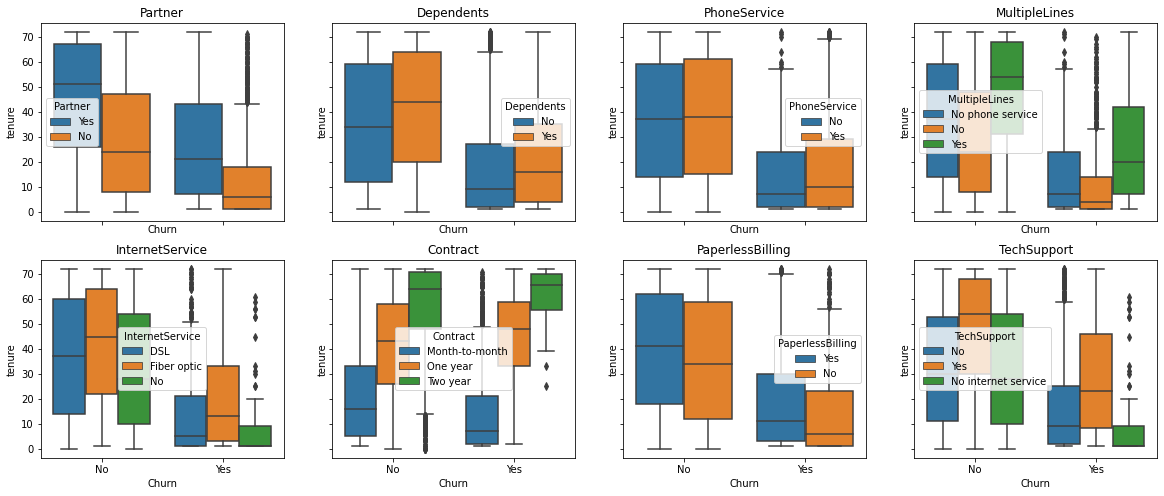

In [10]:
#Legend colors might be confusing!
fig, ax = plt.subplots(2,4, sharey=True, sharex=True, figsize=(20,8))
ax = ax.flatten()
for i,j in enumerate(cols[2:]):
    sns.boxplot('Churn', 'tenure', hue=j, data=telco_df, ax=ax[i])
    ax[i].set_title(j)

**High level observations**

1. Those with partners or dependents have longer tenure than those without. Decision not up to one person.
2. Those with multiple line phone survice have much longer tenure. Availing multiple lines suggests commitment (?)
3. Fiber users seems to stay longer which makes sense as Fiber is bettern than DSL (Note: while we have unique customerID, there might be duplicate customers e.g. those switching from DSL to Fiber)
4. As expected type of contract seems to be associated with tenure. It's easier to leave when contract is shorter.
5. The convenience brought by paperless billing and the help of tech support seems to make subscribers stay longer

In [11]:
#Internet Service Only
print(telco_df.shape)
telco_df = telco_df.query("InternetService!='No'")
print(telco_df.shape)
telco_df = telco_df.set_index('customerID')
telco_df = telco_df[cols]
for c in telco_df.columns:
    print(f'{c}: {telco_df[c].unique()}')

(7043, 21)
(5517, 21)
tenure: [ 1 34  2 45  8 22 10 28 62 13 58 49 25 69 71 21 30 47 72 17 27  5 46 11
 70 63 52 43 15 60 18 66  9  3 31 64 56  7 42 35 29 65 12 38 68 32 55 37
 36 33 67 23 61 14 16 20 53  4 40  6 59 44 19 57 24 54 50 41 51 48 26  0
 39]
Churn: ['No' 'Yes']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
TechSupport: ['No' 'Yes']


In [12]:
#Create new feature
telco_df['MultipleUser'] = (telco_df.Partner == 'Yes') | (telco_df.Dependents == 'Yes')

#To boolean
telco_df['Churn'] = telco_df.Churn == 'Yes'

[Why drop one dummy variable?](https://datascience.stackexchange.com/questions/27957/why-do-we-need-to-discard-one-dummy-variable)

In [13]:
data = pd.get_dummies(
    telco_df[set(cols).difference(['tenure', 'Churn'])], 
    drop_first=True).join(
        telco_df[['tenure', 'Churn']]
)
data.head()

,Partner_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PhoneService_Yes,InternetService_Fiber optic,PaperlessBilling_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,tenure,Churn
customerID,,,,,,,,,,,,
7590-VHVEG,1,0,0,0,0,0,1,0,1,0,1,False
5575-GNVDE,0,0,1,0,1,0,0,0,0,0,34,False
3668-QPYBK,0,0,0,0,1,0,1,0,0,0,2,True
7795-CFOCW,0,1,1,0,0,0,0,0,1,0,45,False
9237-HQITU,0,0,0,0,1,1,1,0,0,0,2,True


## Select features


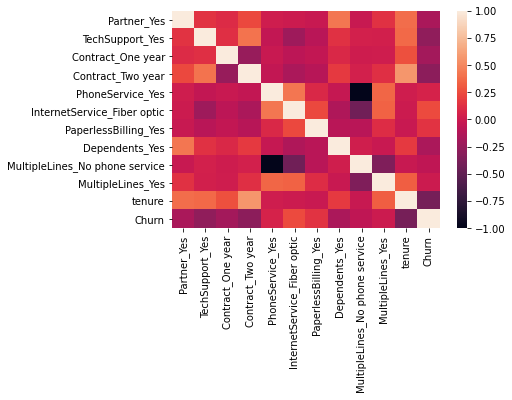

In [14]:
ax = sns.heatmap(data.corr())

In [15]:
#drop phone service! Can be deduced from MultipleLines 
#else, multicollinearity, will result to singular matrix
data = data.drop(['PhoneService_Yes'], axis=1)

## Split dataset

In [16]:
#60% - train set
#20% - validation set
#20% - test set
train_df, validate_df, test_df = np.split(data, [int(.6*len(data)), int(.8*len(data))])
data
print(train_df.shape, validate_df.shape, test_df.shape)

(3310, 11) (1103, 11) (1104, 11)


# Survival analysis

```
Survival Function - P(T>t)
Hazard Function   - P(T>t+d | T>t) ... Rate of decrease of survival curve
Hazard Ratio      - H(x=1) / H(x=0) ... e.g. those exposed is twice at risk as those who are not

```
## Kaplan-Meier

- non parametric   
- pros: simple to interpret, can estimate S(t). 
- cons: no functional form, cannot estimate HR, only handles categorical (and only few) variables

In [17]:
from lifelines.utils import survival_table_from_events

T = train_df['tenure']
E = train_df['Churn']
table = survival_table_from_events(T, E)
table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,3,0,3,3310,3310
1,274,190,84,0,3307
2,128,78,50,0,3033
3,98,45,53,0,2905
4,89,54,35,0,2807
...,...,...,...,...,...
68,49,5,44,0,410
69,41,4,37,0,361
70,55,4,51,0,320


**Looking as a whole (Survival function)**

<AxesSubplot:xlabel='timeline'>

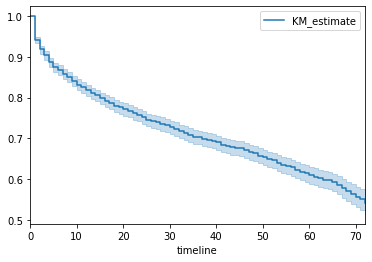

In [18]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)
kmf.plot_survival_function()

<AxesSubplot:xlabel='timeline'>

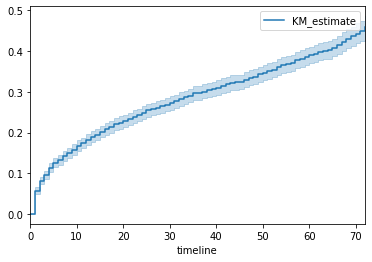

In [19]:
kmf.plot_cumulative_density()

In [20]:
from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_,median_confidence_interval_)

inf      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     inf                     inf


**Segment by type of contract**

- As expected from boxplots above

(0.0, 1.1)

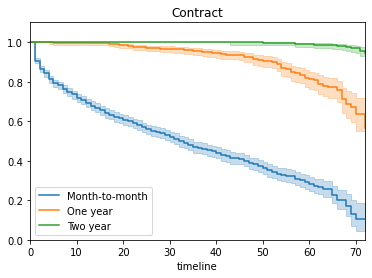

In [21]:
ax = plt.subplot(111)
group = 'Contract'
for name, df in telco_df.groupby(group):
    idx = telco_df.loc[train_df.index][group] == name
    kmf = sv.KaplanMeierFitter().fit(T[idx], E[idx], alpha=0.05, label=name)
    kmf.plot_survival_function(ax=ax)
plt.title(group)
plt.ylim(0, 1.1)

**Estimate Hazard -- The Nelson-Aalen estimator**

,NA_estimate
timeline,
0.0,0.000000
1.0,0.057454
2.0,0.083171
3.0,0.098662
4.0,0.117899
...,...
68.0,0.557899
69.0,0.568979
70.0,0.581479


<AxesSubplot:xlabel='timeline'>

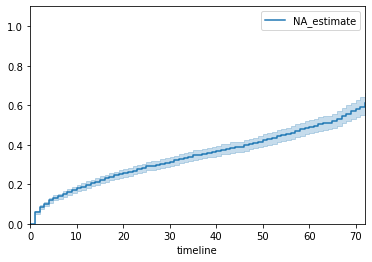

In [22]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter(alpha=0.05, nelson_aalen_smoothing = False).fit(T, E)
display(naf.cumulative_hazard_)
plt.ylim(0, 1.1)
naf.plot()

Text(0.5, 1.0, 'Contract')

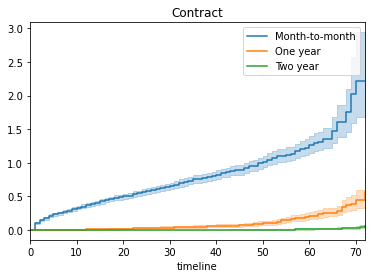

In [23]:
#Can be described more intuitively usnig HR
ax = plt.subplot(111)
group = 'Contract'
for name, df in telco_df.groupby(group):
    idx = telco_df.loc[train_df.index][group] == name
    naf = NelsonAalenFitter().fit(T[idx], E[idx], label=name)
    naf.plot(ax=ax)
plt.title(group)

## Parametric models

- E.g Exponential
- parametric
- pros: exp(-ht), can estimate S(t)and H.R. but not always realistic as it assumes constant hazard.
- cons: Weibull model allows increasing/decreasing hazard porportional to time
- exp(bk)--> hazard ratio (when modeling log hazard)


In [24]:
#ValueError: This model does not allow for non-positive durations. 
#Suggestion: add a small positive value to zero elements.

T.loc[T==0] = .001 #not sure if this is a good value already

<AxesSubplot:>

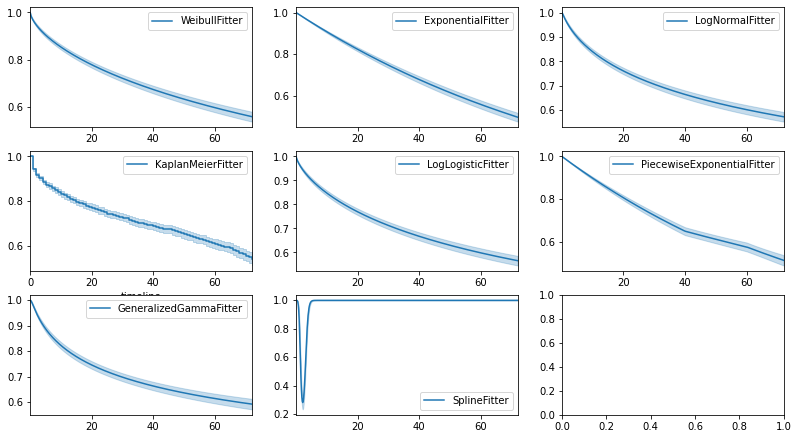

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import *

fig, axes = plt.subplots(3, 3, figsize=(13.5, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
sf = SplineFitter(np.percentile(T.loc[E.astype(bool)], [0, 50, 100])).fit(T, E, label='SplineFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[2][0])
sf.plot_survival_function(ax=axes[2][1])

## Cox PH

- semi parametric
- pros: the hazard can fluctuate with time,  can estimate HR, quite good for effect size models - more realistic HR
- cons: cannot estimate the S(t) so does not work for preditive model 


In [26]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(train_df, duration_col='tenure', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3310 total observations, 2260 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 3310
number of events observed = 1050
   partial log-likelihood = -7229.72
         time fit was run = 2020-10-20 14:36:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
Partner_Yes                     -0.58       0.56       0.07            -0.72            -0.43                 0.49                 0.65
TechSupport_Yes                 -0.64       0.53       0.09            -0.81            -0.47                 0.45                 0.63
Contract_One year               -1.87       0.15       0.12            -2.10            -1.64                 0.12                 0.19
Contract_Two year               -3.83       0.02       0.26            -4.34            -3.32                 0.01                 0.04
InternetService_Fiber optic      0.43       1.53       0.09             0.25             0.60                 1.29                 1.83
PaperlessBilling_Yes             0.14       1.15       0.08            -0.01             0.28                 0.99                 1.33
Dependents_Yes                  -0.15       0.86       0.09            -0.33             0.02                 0.72                 1.02
MultipleLines_No phone service  -0.13       0.88       0.13            -0.38             0.13                 0.68                 1.13
MultipleLines_Yes               -0.57       0.56       0.07            -0.71            -0.44                 0.49                 0.65

                                    z      p   -log2(p)
covariate                                              
Partner_Yes                     -7.93 <0.005      48.74
TechSupport_Yes                 -7.28 <0.005      41.41
Contract_One year              -16.08 <0.005     190.83
Contract_Two year              -14.61 <0.005     158.07
InternetService_Fiber optic      4.81 <0.005      19.31
PaperlessBilling_Yes             1.81   0.07       3.83
Dependents_Yes                  -1.69   0.09       3.47
MultipleLines_No phone service  -0.99   0.32       1.63
MultipleLines_Yes               -8.23 <0.005      52.22
---
Concordance = 0.82
Partial AIC = 14477.44
log-likelihood ratio test = 1538.86 on 9 df
-log2(p) of ll-ratio test = inf

### Evaluate

<AxesSubplot:xlabel='log(HR) (95% CI)'>

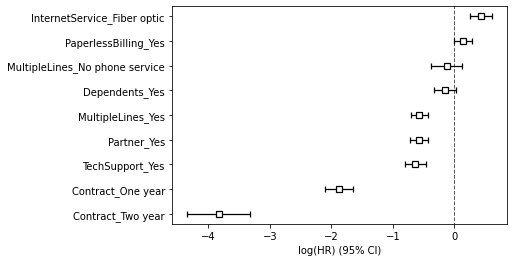

In [27]:
#plot coefficients
#E.g. those with multiple lines is 0.57x likely to terminate service compared to those without multiple lines
cph.plot()

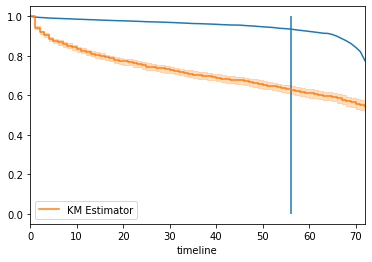

In [28]:
#predict on validation set
surv_pred_train = cph.predict_survival_function(validate_df)
surv_median_pred_train = cph.predict_median(validate_df)

customer_id = surv_pred_train.columns[1]
pred_median = surv_median_pred_train
ax = surv_pred_train[customer_id].plot()
kmf.plot(ax=ax, label='KM Estimator')
plt.vlines(validate_df.loc[customer_id, 'tenure'], ymin=0, ymax=1)
plt.vlines(surv_median_pred_train[customer_id], ymin=0, ymax=1, color='red')

### Check assumptions

```
ASSUMPTIONS: 

1. Non-informative censoring
2. Survival times (t) are independent
3. Hazards are proportional (HR is constant over time) 
    - check c-log-log plot or perform Schoenfeld's test. 
    - Solutions: Stratify on a variable (fit separate model per group), time-dependent coefficients or parameters (adding interaction terms x*t)
4. lm(H) is a linear function of X's (numeric) 
    - we dont have to worry about linearity of categorical variables, check residual plot
    - Solutions: transformations, polynomials, categorize x
5. Values of X don't change over time - Solution : Time-dependent covariates (x) model
6. Baseline hazard (h_o(t)) is unspecified (statement not a assumption)

1,2 --> all models assume these, dependent on study design
3,4 --> assumed for exponential and weibull 
6 --> more of a statement
```

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3310 total observations, 2260 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
Contract_One year              km             39.76 <0.005     31.70
                               rank           31.64 <0.005     25.68
Contract_Two year              km             10.44 <0.005      9.66
                               rank            5.56   0.02      5.77
Dependents_Yes                 km              0.84   0.36      1.48
                               rank            0.94   0.33      1.59
InternetService_Fiber optic    km              8.11 <0.005      7.83
                               rank            8.49 <0.005      8.13
MultipleLines_No phone service km              0.01   0.94      0.09
                               rank            0.00   0.97      0.05
MultipleLines_Yes              km              6.80   0.01      6.78
                               rank            7.86   0.01      7.63
PaperlessBilling_Yes           km              1.69   0.19      2.37
                               rank            2.38   0.12      3.03
Partner_Yes                    km             12.45 <0.005     11.22
                               rank           13.12 <0.005     11.74
TechSupport_Yes                km              7.43   0.01      7.28
                               rank           11.60 <0.005     10.57



1. Variable 'Partner_Yes' failed the non-proportional test: p-value is 0.0003.

   Advice: with so few unique values (only 2), you can include `strata=['Partner_Yes', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'TechSupport_Yes' failed the non-proportional test: p-value is 0.0007.

   Advice: with so few unique values (only 2), you can include `strata=['TechSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'Contract_One year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


4. Variable 'Contract_Two year' failed the non-proportional test: p-value is 0.0012.

   Advice: with so few uniqu

[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0003)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0004)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0007)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0064)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0000)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0000)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0183)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0012)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0036)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0044)'>],
 [<AxesSubplot:xlabel='rank-transformed time\n(p=0.0050)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0091)'>]]

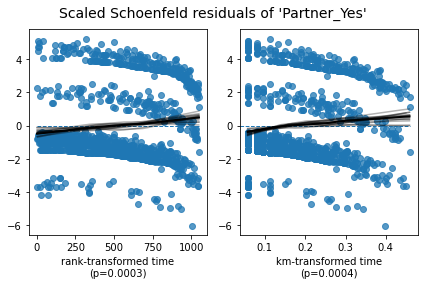

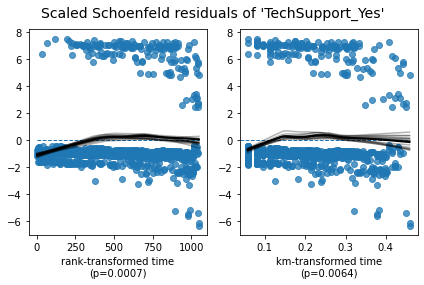

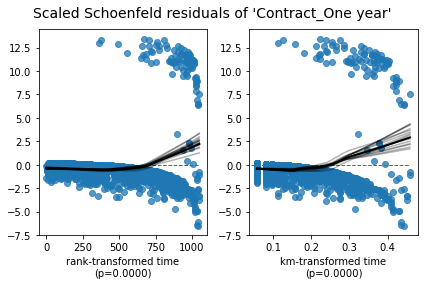

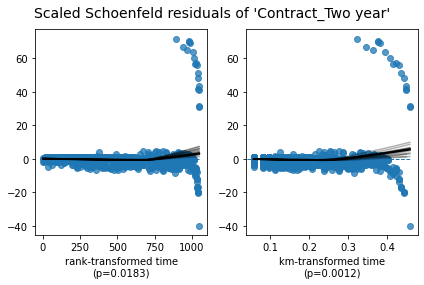

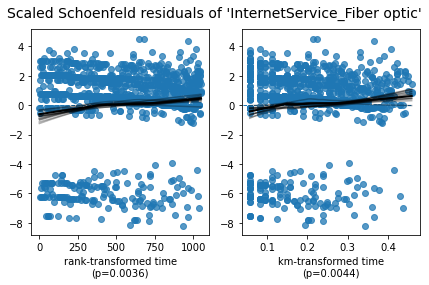

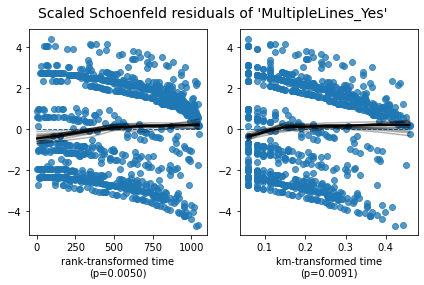

In [29]:
cph.check_assumptions(train_df, p_value_threshold=0.05, show_plots=True)